In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels as sm
import statistics
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARIMA
from datetime import datetime
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from math import sqrt
from sklearn.metrics import mean_squared_error

#from sklearn.ensemble import RandomForestRegressor
import warnings
warnings.filterwarnings("ignore")

df_daily = pd.read_csv("DailyEnergyConsumption_df.csv").set_index("Datetime")
df_weekly = pd.read_csv("WeekyEnergyConsumption_df.csv").set_index("Datetime")

**Autoregressive Integrated Moving Average (ARIMA)**

*train, test split*

In [2]:
#train, test split
X = df_weekly.Total_MW
size = int(len(X) * 0.837)
train_week, test_week = X[0:size], X[size:len(X)]

X_days = df_daily.Total_MW
size = int(len(X_days) * 0.837)
train_day, test_day = X_days[0:size], X_days[size:len(X_days)]

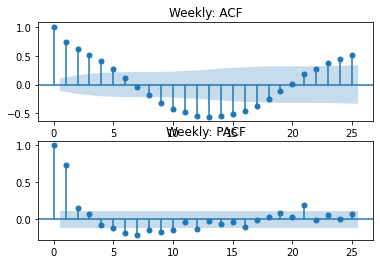

In [3]:
#Weekly: acf, pacf for auto-correlation, partial-autocorrelation
plt.figure()
plt.subplot(211)
plot_acf(X, ax=plt.gca())
plt.title("Weekly: ACF")
plt.subplot(212)
plot_pacf(X, ax=plt.gca())
plt.title("Weekly: PACF")
plt.show()

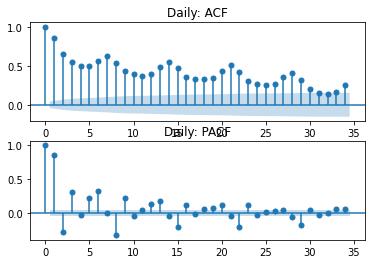

In [4]:
#Daily: acf, pacf for auto-correlation, partial-autocorrelation
plt.figure()
plt.subplot(211)
plot_acf(X_days, ax=plt.gca())
plt.title("Daily: ACF")
plt.subplot(212)
plot_pacf(X_days, ax=plt.gca())
plt.title("Daily: PACF")
plt.show()

*Daily sampled dataset indicates stronger acf, pacf re: # lags*

In [5]:
#build the ARIMA model using weekly dataframe (df_weekly)
from math import sqrt
from sklearn.metrics import mean_squared_error

history = [x for x in train_week]
predictions = list()
for i in range(len(test_week)):
    #predictions
    model = ARIMA(history, order=(6,1,1))  #start with p=6
    model_fit = model.fit()
    yhat = model_fit.forecast()[0]
    predictions.append(yhat)
    #observations
    obs = test_week[i]
    history.append(obs)
    print('>Predicted=%.3f, Expected=%.3f' % (yhat, obs))
#evaluation
rmse = sqrt(mean_squared_error(test_week, predictions))
print('RMSE: %.3f' % rmse)

>Predicted=51547.214, Expected=57730.220
>Predicted=56477.497, Expected=55231.435
>Predicted=54987.889, Expected=49641.423
>Predicted=51702.345, Expected=52380.220
>Predicted=51939.651, Expected=55097.673
>Predicted=53798.872, Expected=50857.173
>Predicted=52111.244, Expected=49892.060
>Predicted=50327.258, Expected=46148.762
>Predicted=47149.033, Expected=50003.262
>Predicted=49567.932, Expected=49242.334
>Predicted=48408.085, Expected=54472.232
>Predicted=52872.197, Expected=47257.786
>Predicted=48660.262, Expected=45016.780
>Predicted=46811.564, Expected=45498.649
>Predicted=45872.070, Expected=43414.054
>Predicted=43473.054, Expected=44255.690
>Predicted=44248.358, Expected=45883.107
>Predicted=44336.600, Expected=44290.208
>Predicted=44693.283, Expected=43809.887
>Predicted=44094.629, Expected=49504.774
>Predicted=47890.932, Expected=44967.071
>Predicted=45578.898, Expected=48259.024
>Predicted=48238.379, Expected=49987.131
>Predicted=48868.599, Expected=60468.101
>Predicted=57680

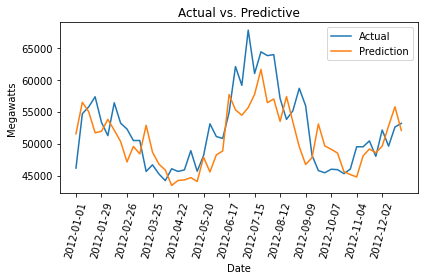

In [6]:
plt.plot(df_weekly.Total_MW[0:52], label='Actual')
plt.plot(predictions, label="Prediction")
plt.xticks(np.arange(0, len(predictions), 4))
plt.xticks(rotation=75)
plt.xlabel("Date")
plt.ylabel('Megawatts')
plt.legend()
plt.title("Actual vs. Predictive")
plt.tight_layout()
plt.savefig("Figures/Arima_6_1_1_Model.jpg")

**ARIMA Hyperparameter Grid Search**

*p-values, d-values, q-values*

*Can we obtain a lower RMSE (<4344)?*

*ARIMA (6,1,1) - RMSE: 4093. This suggests the base ARIMA model improves accuracy against the "persistence" model*

*Grid Search (p,d,q) for reducing the RMSE from the previous of 4093.*

In [7]:
# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):

    history = [x for x in train_week]
    # make predictions
    predictions = list()
    for t in range(len(test_week)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test_week[t])
    # calculate RMSE
    rmse = sqrt(mean_squared_error(test_week, predictions))
    return rmse
 
# evaluate (p,d,q) values for ARIMA
def evaluate_models(dataset, p_values, d_values, q_values):
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    rmse = evaluate_arima_model(dataset, order)
                    if rmse < best_score:
                        best_score, best_cfg = rmse, order
                    print('ARIMA%s RMSE=%.3f' % (order,rmse))
                except:
                    continue
    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))

p_values = [1, 3, 5, 7]
d_values = range(0, 3)
q_values = range(0, 3)
warnings.filterwarnings("ignore")
evaluate_models(X, p_values, d_values, q_values)

ARIMA(1, 0, 0) RMSE=4003.898
ARIMA(1, 0, 1) RMSE=3952.816
ARIMA(1, 0, 2) RMSE=3968.809
ARIMA(1, 1, 0) RMSE=4190.792
ARIMA(1, 1, 1) RMSE=4102.189
ARIMA(1, 2, 0) RMSE=5871.434
ARIMA(3, 0, 0) RMSE=3944.712
ARIMA(3, 0, 1) RMSE=3978.776
ARIMA(3, 0, 2) RMSE=3703.401
ARIMA(3, 1, 0) RMSE=4127.140
ARIMA(3, 1, 1) RMSE=4121.509
ARIMA(3, 1, 2) RMSE=4032.369
ARIMA(3, 2, 0) RMSE=4767.106
ARIMA(3, 2, 1) RMSE=4154.189
ARIMA(3, 2, 2) RMSE=4134.619
ARIMA(5, 0, 0) RMSE=3996.055
ARIMA(5, 1, 0) RMSE=4079.435
ARIMA(5, 1, 1) RMSE=4079.870
ARIMA(5, 1, 2) RMSE=4055.057
ARIMA(5, 2, 0) RMSE=4293.169
ARIMA(5, 2, 1) RMSE=4108.136
ARIMA(7, 0, 0) RMSE=3775.914
ARIMA(7, 0, 1) RMSE=3699.005
ARIMA(7, 0, 2) RMSE=3683.580
ARIMA(7, 1, 0) RMSE=4087.666
ARIMA(7, 1, 1) RMSE=3787.437
ARIMA(7, 2, 0) RMSE=4327.566
ARIMA(7, 2, 1) RMSE=4108.550
Best ARIMA(7, 0, 2) RMSE=3683.580


*ARIMA(7,0,2) - RMSE = 3684*

*These parameters improve on the model accuracy*

**Residual Errors from ARIMA**

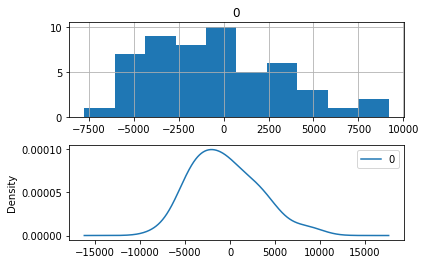

In [8]:
history = [x for x in train_week]
predictions = list()

for i in range(len(test_week)):
    model = ARIMA(history, order=(7,0,2))
    model_fit = model.fit()
    yhat = model_fit.forecast()[0]
    predictions.append(yhat)
    #observations
    obs = test_week[i]
    history.append(obs)
        
#residual errors
residuals = [test_week[i]-predictions[i] for i in range(len(test_week))]
residuals = pd.DataFrame(residuals)

#plot residuals        
plt.figure()
plt.subplot(211)
plt.title("Residuals")
residuals.hist(ax=plt.gca())
plt.subplot(212)
residuals.plot(kind='kde', ax=plt.gca())
plt.show()

In [9]:
#where does the residuals lie relative to '0'?
print(residuals.describe())

                 0
count    52.000000
mean   -541.936613
std    3677.286817
min   -7754.760442
25%   -3095.619860
50%    -880.243223
75%    1848.118664
max    9188.748368


*bias = mean = -547*

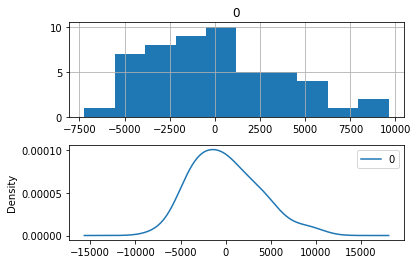

In [10]:
#correct residual bias imbalance
history = [x for x in train_week]
predictions = list()
bias = -547
for i in range(len(test_week)):
    model = ARIMA(history, order=(7,0,2))
    model_fit = model.fit()
    yhat = model_fit.forecast()[0]
    yhat = bias + yhat
    predictions.append(yhat)
    #observations
    obs = test_week[i]
    history.append(obs)
        
#residual errors
residuals = [test_week[i]-predictions[i] for i in range(len(test_week))]
residuals = pd.DataFrame(residuals)

#plot residuals        
plt.figure()
plt.subplot(211)
residuals.hist(ax=plt.gca())
plt.subplot(212)
residuals.plot(kind='kde', ax=plt.gca())
plt.show()

In [11]:
print(residuals.describe())

                 0
count    52.000000
mean     -5.567806
std    3657.041676
min   -7233.685844
25%   -2521.647453
50%    -310.888031
75%    2397.680532
max    9623.590078


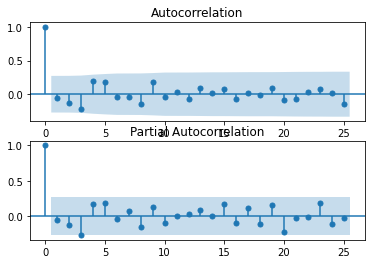

In [12]:
#plot re-calculated acf, pacf
plt.figure()
plt.subplot(211)
plot_acf(residuals, lags=25, ax=plt.gca())
plt.subplot(212)
plot_pacf(residuals, lags=25, ax=plt.gca())
plt.show()

*The autocorrelation has been captured in ARIMA Model; no autocorrelation in residuals*

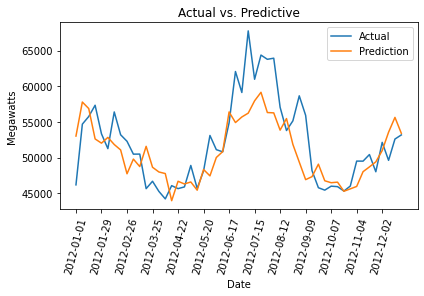

In [17]:
plt.plot(df_weekly.Total_MW[0:52], label='Actual')
plt.plot(predictions, label="Prediction")
plt.xticks(np.arange(0, len(predictions), 4))
plt.xticks(rotation=75)
plt.xlabel("Date")
plt.ylabel('Megawatts')
plt.legend()
plt.tight_layout()
plt.title("Actual vs. Predictive")
plt.savefig("Figures/ARIMA_7_0_2.jpg")